In [1]:
#import av
import numpy as np
import math
from skimage.morphology import *
from skimage.feature import *
import matplotlib.pyplot as plt #for maknig plots inside the notebook
import skimage
import skvideo.io
from operator import attrgetter
import seaborn as sns
from operator import attrgetter
from itertools import chain
from skimage import measure
from skimage import morphology
from skimage.util import invert
from skimage.filters import *
from scipy import ndimage
from glob import glob
from skvideo.io import vreader
"""Currently works on a single frame. Later, will add a loop that can work on all frames."""

'Currently works on a single frame. Later, will add a loop that can work on all frames.'

In [2]:
# take largest isodata image region, and return aclassification
def sideify(ptotallengths,gtotallengths,mtotallengths,
                num_pconnections, num_gconnections, num_mconnections):    
    if num_pconnections == 1 and num_gconnections ==0 and num_mconnections==4: #gtotallengths>48
        return "p"
    elif num_pconnections == 0 and num_gconnections ==1 and num_mconnections == 4:
        return "g"
    elif num_pconnections == 1 and num_gconnections ==1 and num_mconnections ==3:
        return "b"
    else:
        return "ucf"
    
def connect(cv, radius, bloblist): # center of blob2, radius of all blobs, list of other blobs
    num_connections = 0
    norm_radius = 15
    total_separations = 0
    normalized_dists = []
    for blob2 in bloblist:
        cv2 = (blob2[1], blob2[0]) # center of blob2
        vector_d = vector_dist(cv, cv2)
        total_separations += vector_d
        if vector_d <= 2*radius and vector_d > .33*radius: # blob centers closer than diameter of one blob
            num_connections += 1
        else:
            pass
        normalized_dists.append(vector_d/(2*norm_radius))
    return (num_connections, normalized_dists, total_separations)

def vector_dist(v1, v2): # euclidean distance between 2 points
    return math.sqrt(np.sum([(v1[i] - v2[i])**2 for i in range(len(v1))]))

def third_item(l1):
        return l1[2]        

#from pair of labelled, thresholded images, return an image category (of three)

#from pair of labelled,thresholded images, return the x/y sign or x/y magnitude for the transparent dot


In [3]:
connect_test = connect((0, 0),2, [(0, 3, 1), (3, 3, 1.1), (0, 0, 5), (9, 9, 100)]) #2
vector_dist_test = [vector_dist((-3, 0), (0, 4)), vector_dist((1,1,0), (1,7,8))]
third_item_test = third_item([0, "99", "hello", [55, 67]])
print(connect_test, vector_dist_test , third_item_test )

(1, [0.1, 0.1414213562373095, 0.0, 0.4242640687119285], 19.97056274847714) [5.0, 10.0] hello


In [4]:
grp1 = [1, [95, 67], 2]
grp2 = [2, [9.0], 13]
print(grp1+grp2)
print([grp1[i]+grp2[i] for i in range(len(grp1))])

[1, [95, 67], 2, 2, [9.0], 13]
[3, [95, 67, 9.0], 15]


In [5]:
"Filtering broken ad oddframes"
"USING LI THRESHOLD"
# apply total thresholding to each of a list of frames; filter slides with wrong number
def total_threshold_filter(framelist, framesetname): 
    # returns a new list, different from the orginal
    fll = len(framelist)
    m_lab = measure.label
    m_rop = measure.regionprops
    expected_blobs = 4
    expected_connections = 5
    p_bond = 15*1.5
    g_bond = 15*1.5
    m_bond = 15*1.8
    
    filtrate_prop =[]
    passes = []
    all_props = []
    blobset = [] #labelled imgs
    for i in range(fll):
       # ---setup image and detect blobs ----------------
        if framesetname == 'broken' or framesetname == 'odd_s':
            framesetname = 'ucf'
        frame = framelist[i]
        thresh_img = frame > threshold_isodata(frame)# binary image
        
        phighlight = morphology.binary_opening(thresh_img, square(19))
        img = np.copy(frame)
        img[phighlight==0] = 0
        pblobs =skimage.feature.blob_doh(img, min_sigma =8, max_sigma = 17, threshold = 0.007, num_sigma= 15, overlap=0.3)
        
        ghighlight = gaussian(morphology.white_tophat(
                            morphology.binary_opening(thresh_img ^ morphology.binary_dilation(phighlight, square(3)),
                                                      square(6)),
                            disk(5)), sigma = 0.7)
        img = np.copy(frame)
        img[ghighlight==0] = 0
        gblobs =skimage.feature.blob_doh(img, min_sigma =9, max_sigma = 16, threshold = 0.009, num_sigma= 15, overlap=0.7)
    
        
        blobset.append([pblobs, gblobs])
        ngblobs = len(gblobs)
        npblobs = len(pblobs) 
        num_blobs = ngblobs + npblobs  
        
        plas_on_glas_dists =[connect((pblob[1], pblob[0]),m_bond, gblobs) for pblob in pblobs]
        plas_on_glas_dists = [sum([pog[0] for pog in plas_on_glas_dists]), 
                              list(chain(*[pog[1] for pog in plas_on_glas_dists])),
                             sum([pog[2] for pog in plas_on_glas_dists])]
        num_mconnections = plas_on_glas_dists[0]
        mdistances = plas_on_glas_dists[1]
        mtotallengths = plas_on_glas_dists[2]
        
        glas_on_glas_dists =[connect((gblobs[i][1], gblobs[i][0]),g_bond, gblobs[i+1:]) for i in range(ngblobs-1)]
        glas_on_glas_dists = [sum([gog[0] for gog in glas_on_glas_dists]), 
                              list(chain(*[gog[1] for gog in glas_on_glas_dists])),
                             sum([gog[2] for gog in glas_on_glas_dists])]
        num_gconnections = glas_on_glas_dists[0]
        gdistances = glas_on_glas_dists[1]
        gtotallengths = glas_on_glas_dists[2]
        
        plas_on_plas_dists = [connect((pblobs[i][1], pblobs[i][0]),p_bond, pblobs[i+1:]) for i in range(npblobs-1)]
        plas_on_plas_dists = [sum([pop[0] for pop in plas_on_plas_dists]), 
                              list(chain(*[pop[1] for pop in plas_on_plas_dists])),
                             sum([pop[2] for pop in plas_on_plas_dists])]
        num_pconnections = plas_on_plas_dists[0]
        pdistances = plas_on_plas_dists[1]
        ptotallengths = plas_on_plas_dists[2]
        
        
        
        num_connections = sum([num_pconnections, num_gconnections,num_mconnections])
        distances = list(chain(pdistances, gdistances, mdistances))       
        totallengths = sum([ptotallengths, gtotallengths, mtotallengths])
        
        #----------------------filter------------------------- can use actual filter
        properties = {'num_blobs':num_blobs,
                      'num_pblobs':npblobs,
                      'num_gblobs':ngblobs,
                      'num_connections': num_connections,
                      'num_pconnections':num_pconnections, 
                      'num_gconnections':num_gconnections, 
                      'num_mconnections':num_mconnections,
                     'totallengths':totallengths, 
                      'ptotallengths':ptotallengths, 
                      'gtotallengths':gtotallengths, 
                      'mtotallengths':mtotallengths,
                     'distances':distances, 
                      'pdistances':pdistances, 
                      'gdistances':gdistances, 
                      'mdistances':mdistances}
        #print(properties)
        all_props.append(properties)
        
        #print('blobs, max_blob, max_rad, num_connections, cons_of_max:', (blobs, max_blob, max_rad, num_connections, cons_of_max))    
        test = True
        if test: 
            #-----------------------------classify pt 1---------------------------------------
            clas = sideify(ptotallengths,gtotallengths,mtotallengths,
                num_pconnections,num_gconnections, num_mconnections )
            filtrate_prop.append(properties)
        else:
            clas = 'ucf'
        if clas == framesetname:
            passes.append(properties)
            
    return [filtrate_prop, passes, all_props, blobset]






In [6]:
filenames = filename = glob("./tchakamau/half*/*[1][0]v*[1,3,4,6].avi")#[1,3,4,5]glob("./tchakamau/New_setup/*.avi")# glob("./tchakamau/New_setup/45681_10Vpp_25.avi") #filenames = 
print(filenames)
num_shape_cats = 5
Pass_ratios = np.zeros((len(filenames), num_shape_cats))



"""TEST FRAME RANGES FROM VIDEOs"""
#needs reflled
phantom_frames = {"p" : list(),
                  "g" :[], 
                  "b" :list(),
                 "broken" :[] ,
                 "odd_s" :list() }

#---------------------------------------------------
phantom_frames_2 = {"p" : list(range(46297, 45476, -3)),
                  "g" :list(range(43467, 41900, -3)), 
                  "b" :[],
                 "broken" :[],
                 "odd_s" :list(chain(range(41855, 41653, -3), range(43599,43536,-1), range(44756, 44444, -3),
                                     range(45458, 45305, -2)))}
phantom_frames_3 = {"p" : list(range(21944, 10399, -28)),
                  "g" :list(range(57193, 50565, -22)), 
                  "b" :list(range(78900, 77197, -4)),
                 "broken" :list(range(66444, 66101, -2)) ,
                 "odd_s" :list(chain(range(81731, 79275, -30), range(75189, 74345, -9), range(66080, 65836, -2))) }
#-----------------------------------
phantom_frames_4 = {"p" : [],
                  "g" :[], 
                  "b" :[],
                 "broken" :[],
                 "odd_s" :[]}

phantom_frame_sets = [phantom_frames,phantom_frames_2,phantom_frames_3, phantom_frames_4]
trigger_frames = [59749,85587,85587,30433]


['./tchakamau\\HalfHalf\\45592_10Vpp_1.avi', './tchakamau\\HalfHalf\\45652_10Vpp_3.avi', './tchakamau\\HalfHalf\\45655_10Vpp_4.avi', './tchakamau\\HalfHalf\\45781_10Vpp_6.avi']


In [7]:
p_frames = []

g_frames = []

b_frames = []

odd_s_frames = []

broken_frames = []


framesets = [p_frames, g_frames, b_frames,  odd_s_frames, 
             broken_frames]
framesetnames = ["p", "g", "b", "odd_s", "broken"]
filtrates_props = []
passes = []
i_props = []
t_props = []    
for vidnum in range(len(filenames)):
    framegen = vreader(filenames[vidnum])
    #frame_vid = frames[:, :, :, 2]# making videos ino a frame list
    print(framegen)
    pvals  = []
    gvals = []
    bvals = []
    oddsvals = []
    brokenvals = []
    frametypevals = [pvals, gvals, bvals, oddsvals, brokenvals]
    
    for framesetind in range(len(framesetnames)):
        typevals = (phantom_frame_sets[vidnum].get(framesetnames[framesetind]))
        frametypevals[framesetind].extend(typevals)
    frameindex = 0
    tf = trigger_frames[vidnum]
    for frame in framegen:
        for framesetind in range(len(framesetnames)):            
            if tf-frameindex in frametypevals[framesetind]:
                framesets[framesetind].append((frame[:,:,2], tf-frameindex))
           
        frameindex += 1
    
    
""" for i in range(len(framesetnames)):
        typevals = phantom_frame_sets[vidnum].get(framesetnames[i])
        
        frames = 
        #print(len(typevals), trigger_frames[vidnum], typevals[-1], typevals[-1]-trigger_frames[vidnum])
        framesets[i].extend([(frame_vid[trigger_frames[vidnum]-x], x) for x in typevals])
"""

<generator object vreader at 0x0000018817F09F48>
<generator object vreader at 0x0000018812753408>
<generator object vreader at 0x0000018817F097C8>
<generator object vreader at 0x0000018812753408>


' for i in range(len(framesetnames)):\n        typevals = phantom_frame_sets[vidnum].get(framesetnames[i])\n        \n        frames = \n        #print(len(typevals), trigger_frames[vidnum], typevals[-1], typevals[-1]-trigger_frames[vidnum])\n        framesets[i].extend([(frame_vid[trigger_frames[vidnum]-x], x) for x in typevals])\n'

In [8]:
filtrates_props = []
passes = []
a_props = []
p_rats = []
limgs = []
for i in range(len(framesetnames)):
    x = total_threshold_filter([y[0] for y in framesets[i]], framesetnames[i])
    filtrates_props.append(x[0])
    passes.append(x[1])
    #all_props.append(x[2])
    #print(framesets[i])

    orig = len(framesets[i])
    fil = len(x[0])
    pas = len(x[1])
    print(orig, fil, pas)
    print(framesetnames[i], "_vid")
    print("original_vid: ", orig)
    print("filtrate: ", fil)
    if orig != 0:
        print("pass ratio: ", pas*100/orig)
        p_rats.append(pas*100/orig)
    print("\n")
        

    a_props.append(x[2])
    limgs.append(x[3])
Pass_ratios = p_rats
Filtrates_props = filtrates_props
st = framesets
np.save('shape_testing.npy',st)
print(len(a_props), len(filtrates_props), len(passes))

687 687 605
p _vid
original_vid:  687
filtrate:  687
pass ratio:  88.06404657933042


825 825 662
g _vid
original_vid:  825
filtrate:  825
pass ratio:  80.24242424242425


426 426 383
b _vid
original_vid:  426
filtrate:  426
pass ratio:  89.90610328638498


610 610 451
odd_s _vid
original_vid:  610
filtrate:  610
pass ratio:  73.93442622950819


172 172 172
broken _vid
original_vid:  172
filtrate:  172
pass ratio:  100.0


5 5 5


In [9]:
names = {'num_blobs':[],
                      'num_pblobs':[],
                      'num_gblobs':[],
                      'num_connections': [],
                      'num_pconnections':[], 
                      'num_gconnections':[], 
                      'num_mconnections':[],
                     'totallengths':[], 
                      'ptotallengths':[], 
                      'gtotallengths':[], 
                      'mtotallengths':[],
                     'distances':[], 
                      'pdistances':[], 
                      'gdistances':[], 
                      'mdistances':[]}
strings = names.keys()
distances = [string for string in strings if 'distances' in string]
simplenames = strings - distances
print(distances, simplenames)

['distances', 'pdistances', 'gdistances', 'mdistances'] {'num_mconnections', 'totallengths', 'num_pconnections', 'num_pblobs', 'num_connections', 'gtotallengths', 'ptotallengths', 'mtotallengths', 'num_blobs', 'num_gconnections', 'num_gblobs'}


num_mconnections averages: 
p : 4 
g : 4 
b : 3 
odd_s : 3 
broken : 1 
num_mconnections variances: 
p : 0 
g : 1 
b : 0 
odd_s : 1 
broken : 1 
totallengths averages: 
p : 217 
g : 201 
b : 240 
odd_s : 206 
broken : 237 
totallengths variances: 
p : 2192 
g : 2466 
b : 1935 
odd_s : 8161 
broken : 46107 
num_pconnections averages: 
p : 1 
g : 0 
b : 1 
odd_s : 1 
broken : 0 
num_pconnections variances: 
p : 0 
g : 0 
b : 0 
odd_s : 0 
broken : 0 


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


num_pblobs averages: 
p : 2 
g : 2 
b : 2 
odd_s : 2 
broken : 1 
num_pblobs variances: 
p : 0 
g : 0 
b : 0 
odd_s : 0 
broken : 0 
num_connections averages: 
p : 5 
g : 5 
b : 5 
odd_s : 4 
broken : 1 
num_connections variances: 
p : 1 
g : 2 
b : 1 
odd_s : 3 
broken : 1 
gtotallengths averages: 
p : 51 
g : 28 
b : 37 
odd_s : 44 
broken : 53 
gtotallengths variances: 
p : 392 
g : 195 
b : 488 
odd_s : 1161 
broken : 6298 
ptotallengths averages: 
p : 36 
g : 53 
b : 36 
odd_s : 32 
broken : 51 
ptotallengths variances: 
p : 25 
g : 129 
b : 12 
odd_s : 313 
broken : 3942 
mtotallengths averages: 
p : 130 
g : 120 
b : 167 
odd_s : 130 
broken : 133 
mtotallengths variances: 
p : 703 
g : 962 
b : 759 
odd_s : 3235 
broken : 13668 
num_blobs averages: 
p : 4 
g : 4 
b : 4 
odd_s : 4 
broken : 3 
num_blobs variances: 
p : 0 
g : 0 
b : 0 
odd_s : 1 
broken : 1 
num_gconnections averages: 
p : 0 
g : 1 
b : 1 
odd_s : 0 
broken : 0 
num_gconnections variances: 
p : 0 
g : 0 
b : 0 


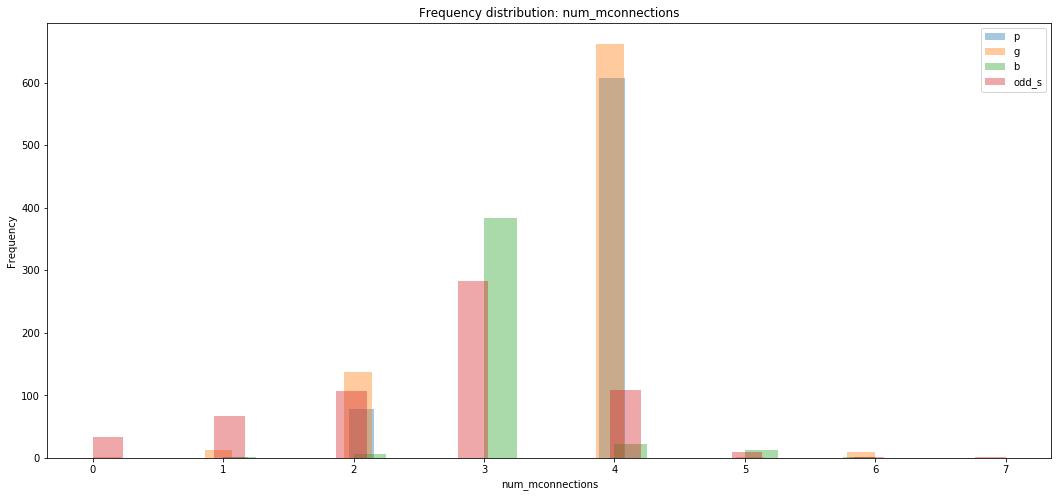

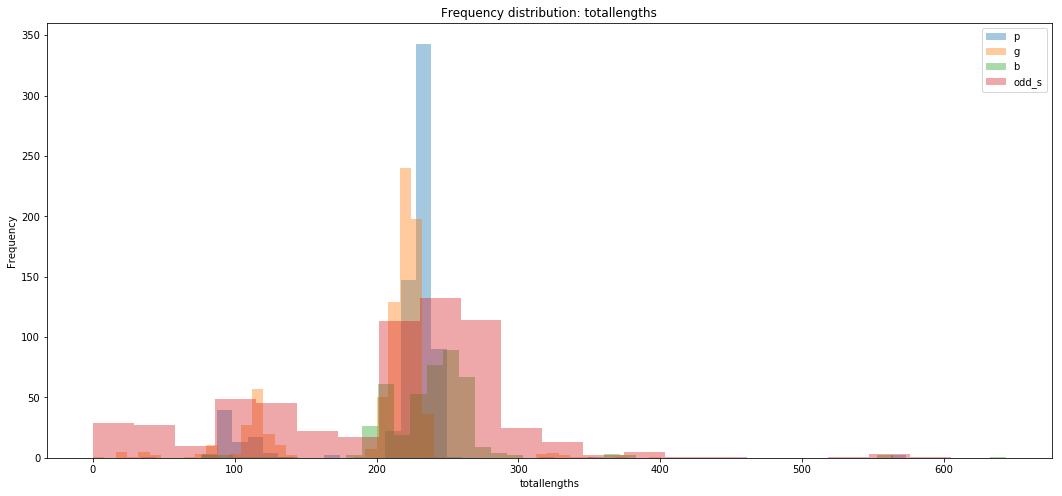

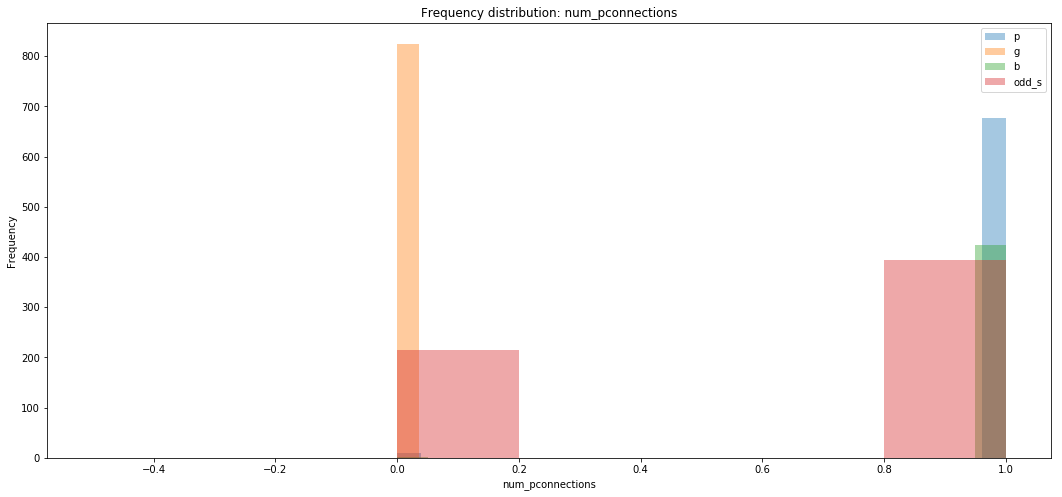

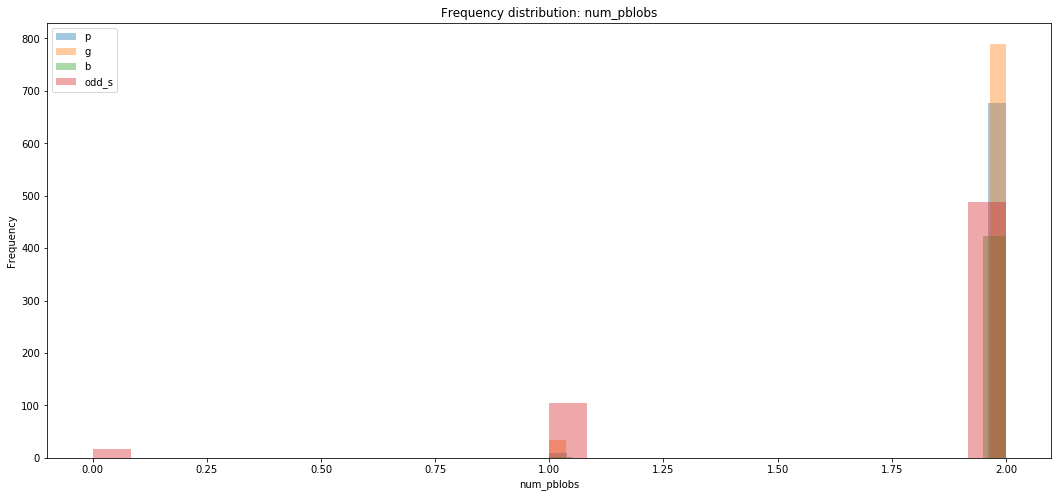

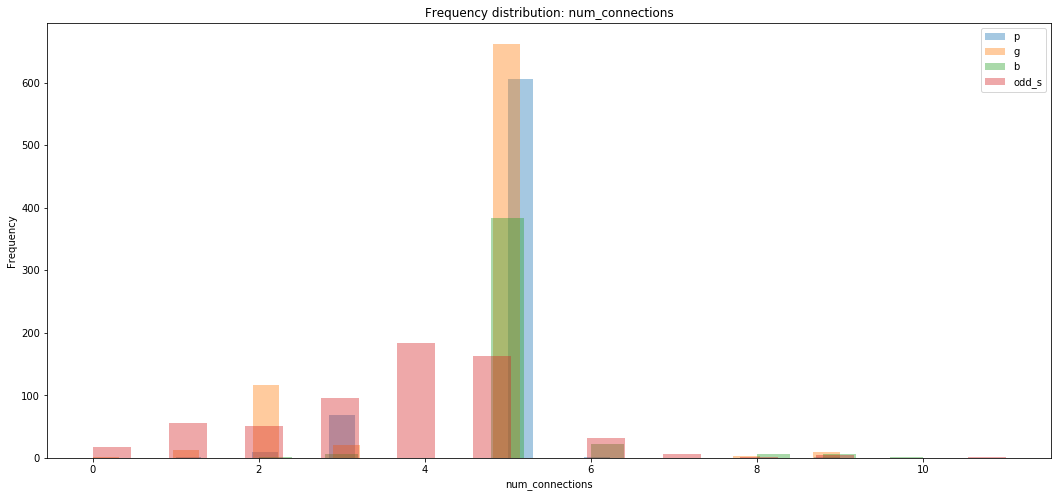

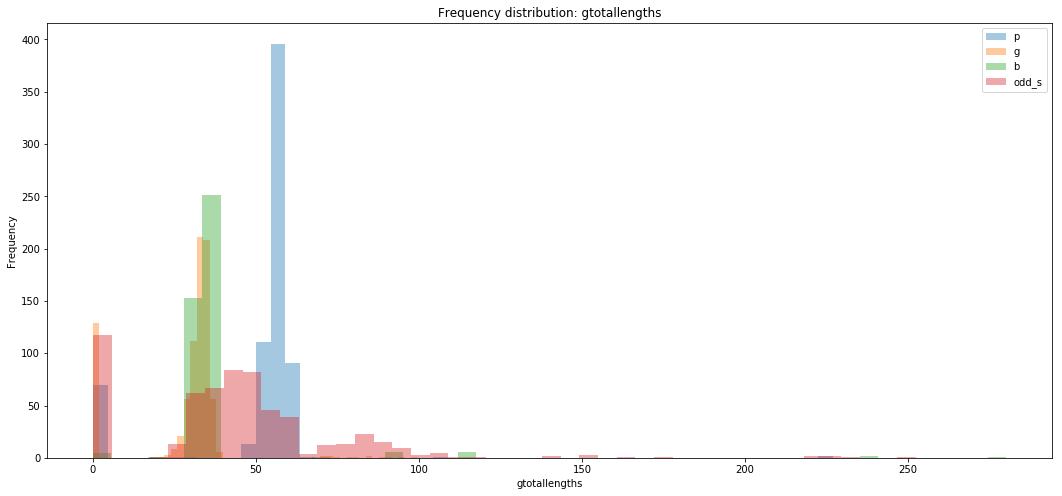

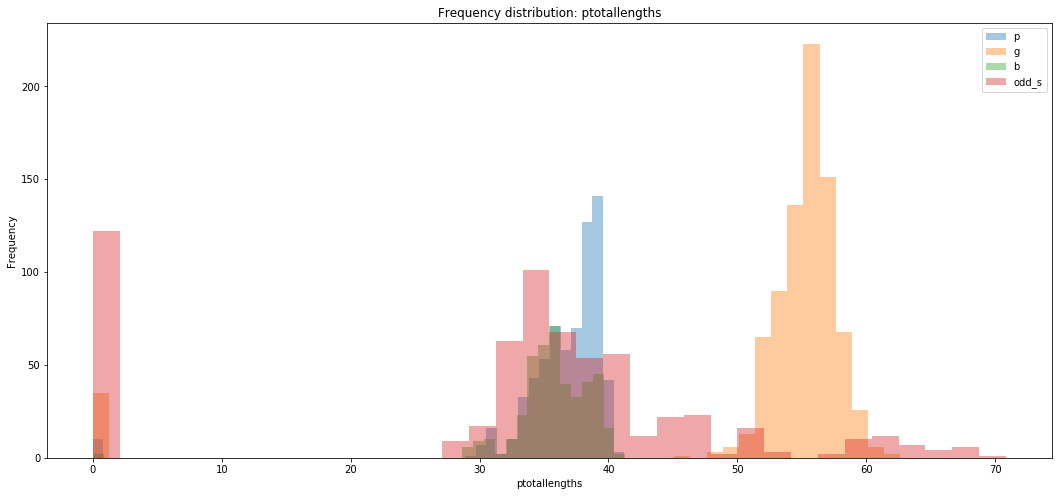

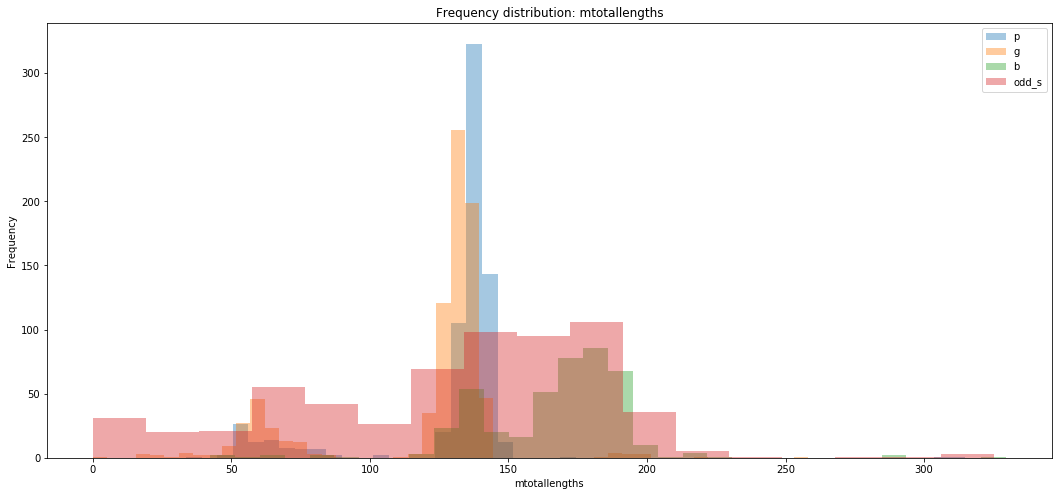

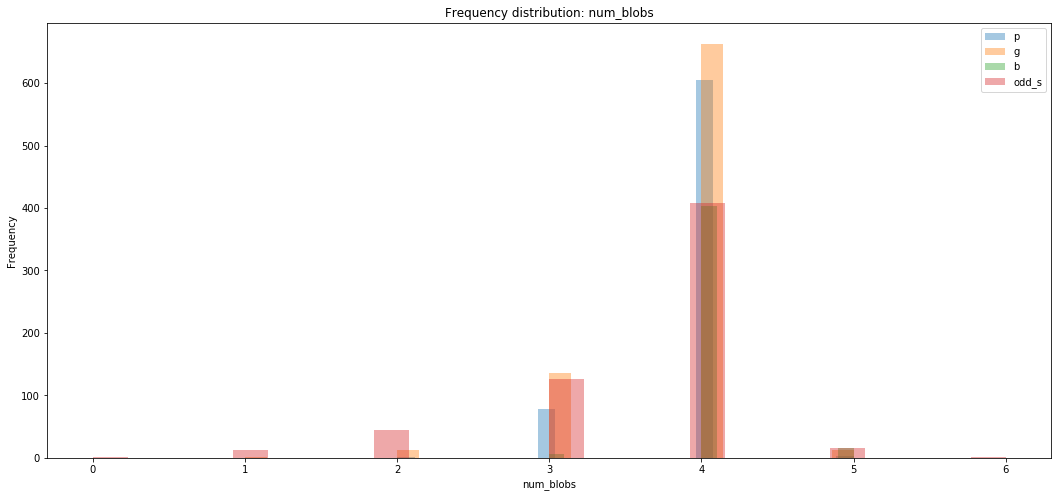

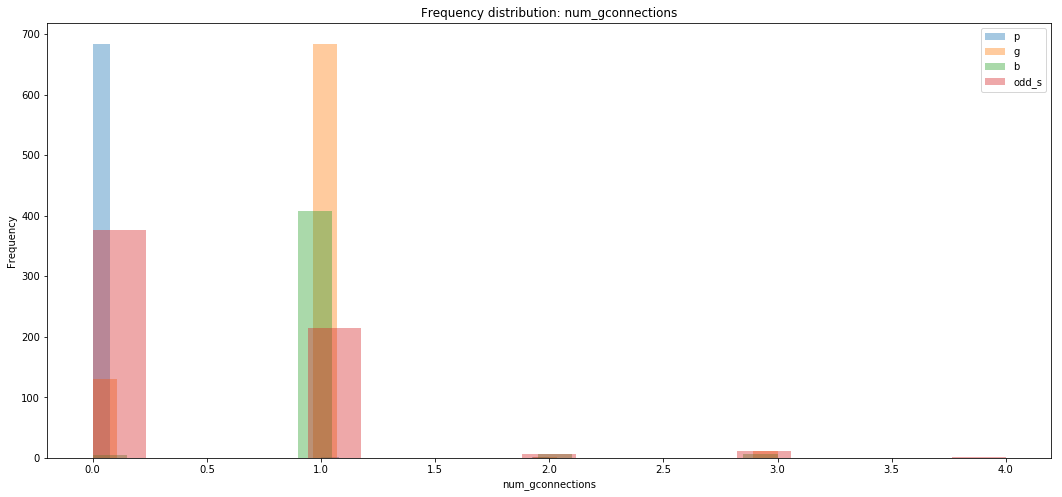

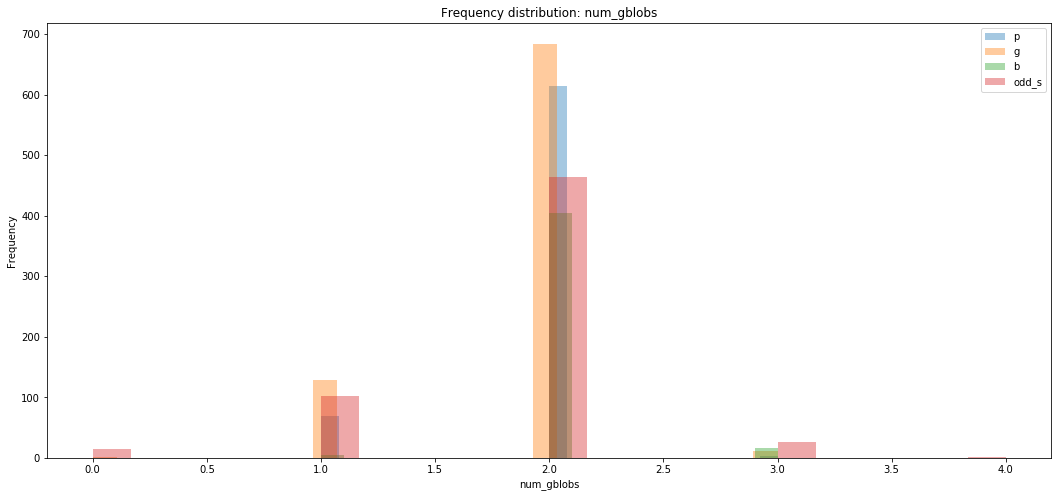

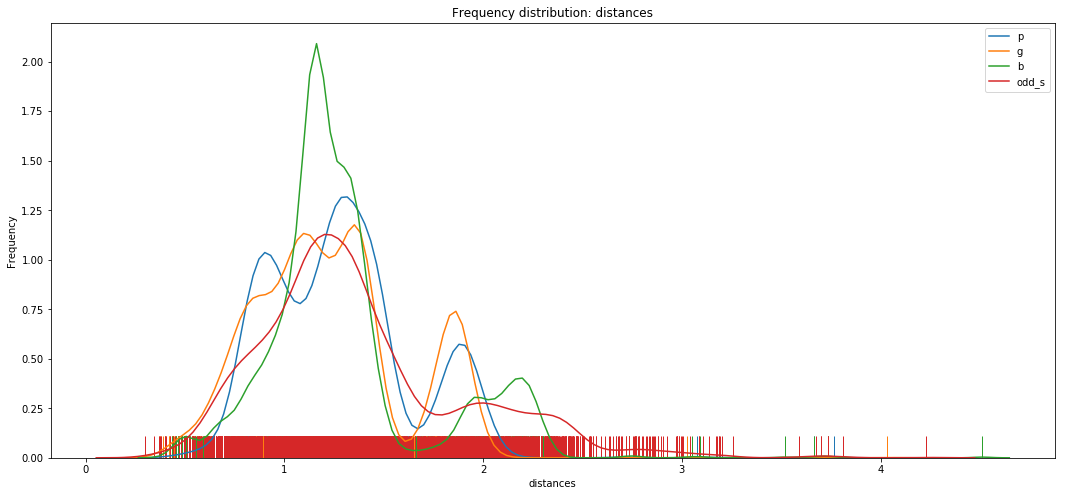

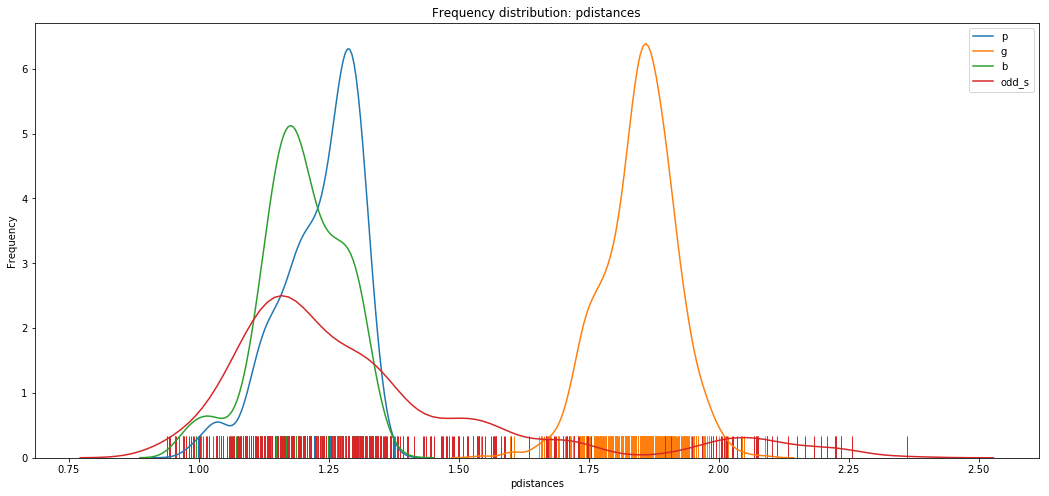

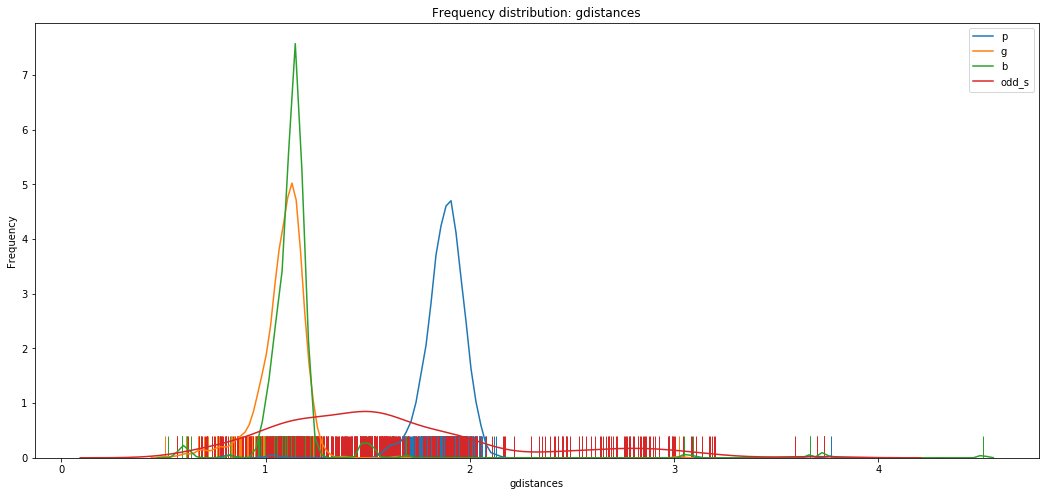

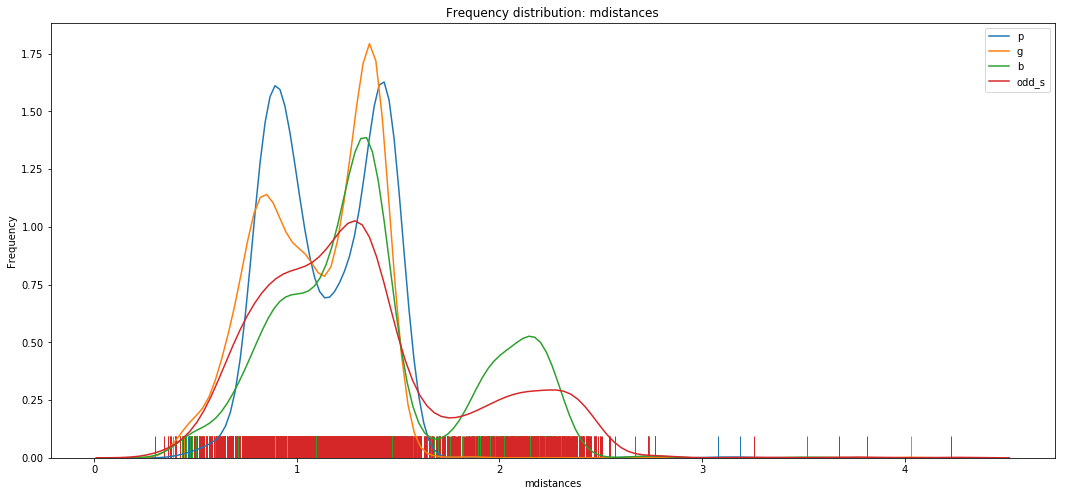

In [10]:
"""Everything"""

# use area information from properties


for name in simplenames:
    klist = []
    for i in range(num_shape_cats):
        x = [h[name] for h in a_props[i]]
        klist.append(x) #list of areas for every category
    print("%s averages: " %name)
    [print("%s : %.f " %(framesetnames[i], np.average(klist[i]))) for i in range(num_shape_cats)]
    print("%s variances: " %name)
    [print("%s : %.f " %(framesetnames[i], np.var(klist[i]))) for i in range(num_shape_cats)]    
    fig, ax = plt.subplots(figsize=(18,8))
    #plt.xticks(np.arange(0, 2501, 75))
    plt.title("Frequency distribution: " + name)
    plt.xlabel(name)
    plt.ylabel("Frequency")
    for j in range(0, num_shape_cats-1):
        x = klist[j]
        sns.distplot(x, hist = True, kde=False,rug=False, label = framesetnames[j])
    plt.legend() 
    
    

    
    
print(len(klist[0]))
for name in distances:
    klist = []
    for i in range(num_shape_cats):
        x = [d for lis in [h[name] for h in a_props[i]] for d in lis]
        klist.append(x) #list of areas for every category
    print(len(klist[0]))
    print("%s averages: " %name)
    [print("%s : %.f " %(framesetnames[i], np.average(klist[i]))) for i in range(num_shape_cats)]
    print("%s variances: "  %name)
    [print("%s : %.f " %(framesetnames[i], np.var(klist[i]))) for i in range(num_shape_cats)]    
    fig, ax = plt.subplots(figsize=(18,8))
    #plt.xticks(np.arange(0, 2501, 75))
    plt.title("Frequency distribution: " +  name)
    plt.xlabel( name)
    plt.ylabel("Frequency")
    for j in range(0, num_shape_cats-1):
        x = klist[j]
        sns.distplot(x, hist = False, rug=True, label = framesetnames[j])




num_mconnections averages: 
p : 4 
g : 4 
b : 3 
odd_s : 3 
broken : 1 
num_mconnections variances: 
p : 0 
g : 1 
b : 0 
odd_s : 1 
broken : 1 
totallengths averages: 
p : 217 
g : 201 
b : 240 
odd_s : 206 
broken : 237 
totallengths variances: 
p : 2192 
g : 2466 
b : 1935 
odd_s : 8161 
broken : 46107 
num_pconnections averages: 
p : 1 
g : 0 
b : 1 
odd_s : 1 
broken : 0 
num_pconnections variances: 
p : 0 
g : 0 
b : 0 
odd_s : 0 
broken : 0 
num_pblobs averages: 
p : 2 
g : 2 
b : 2 
odd_s : 2 
broken : 1 
num_pblobs variances: 
p : 0 
g : 0 
b : 0 
odd_s : 0 
broken : 0 
num_connections averages: 
p : 5 
g : 5 
b : 5 
odd_s : 4 
broken : 1 
num_connections variances: 
p : 1 
g : 2 
b : 1 
odd_s : 3 
broken : 1 
gtotallengths averages: 
p : 51 
g : 28 
b : 37 
odd_s : 44 
broken : 53 
gtotallengths variances: 
p : 392 
g : 195 
b : 488 
odd_s : 1161 
broken : 6298 
ptotallengths averages: 
p : 36 
g : 53 
b : 36 
odd_s : 32 
broken : 51 
ptotallengths variances: 
p : 25 
g : 129

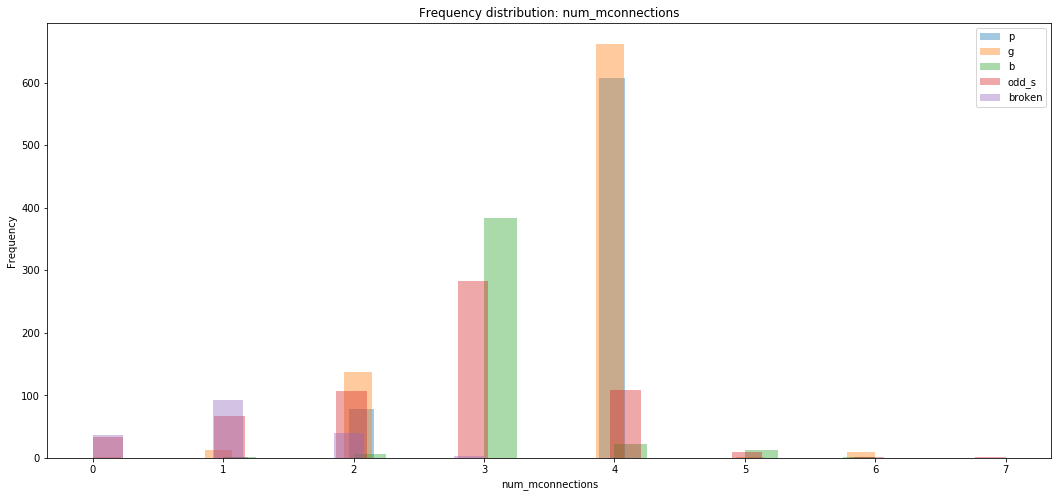

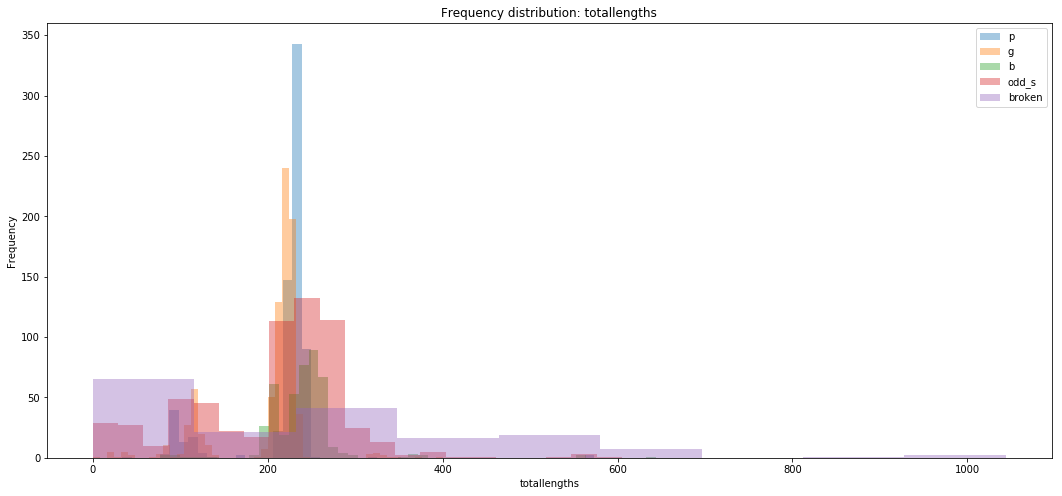

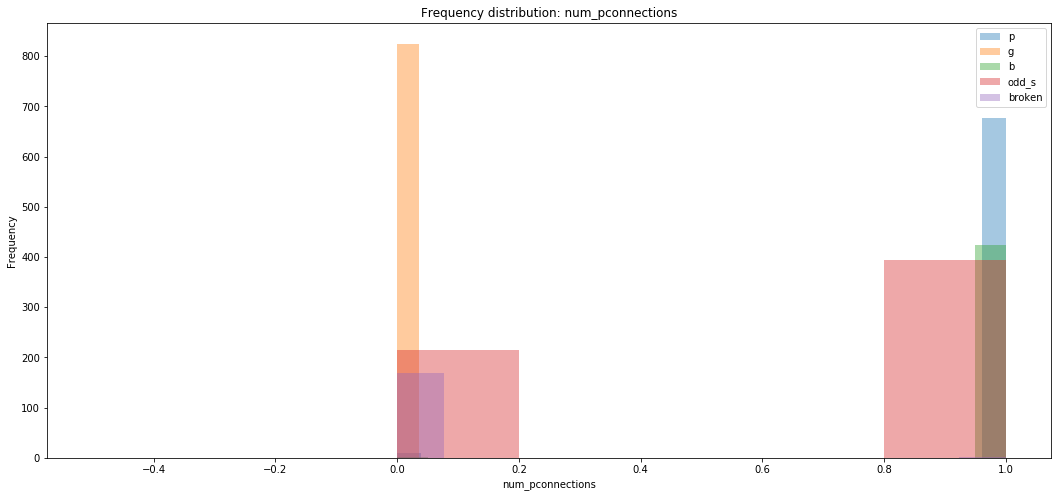

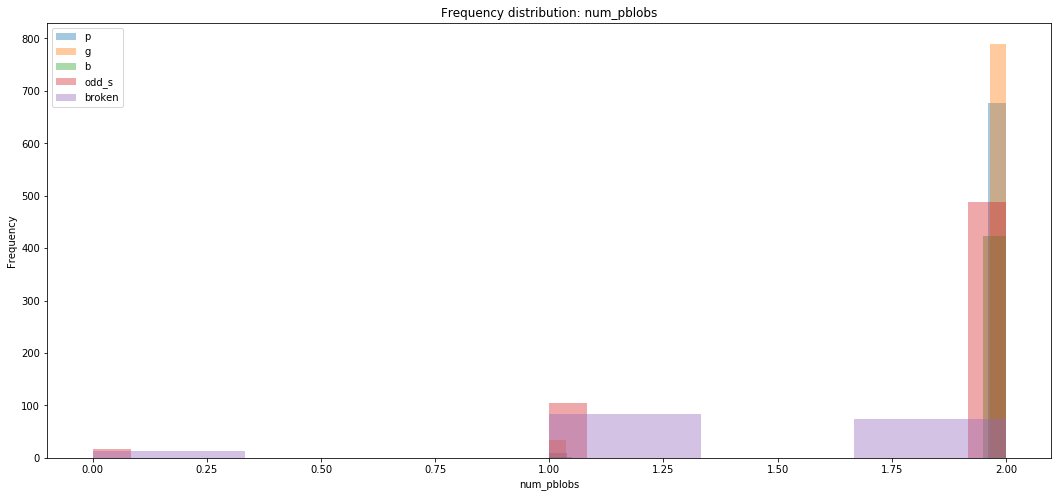

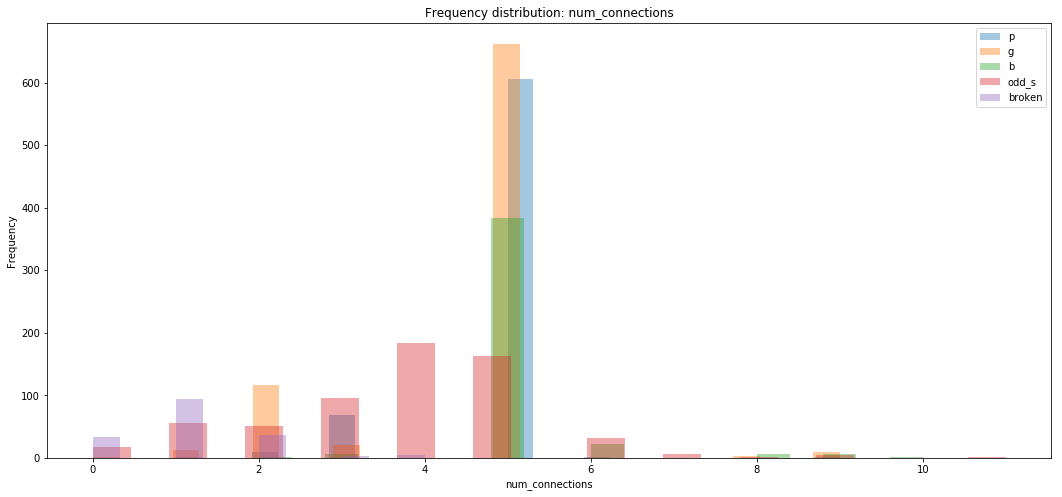

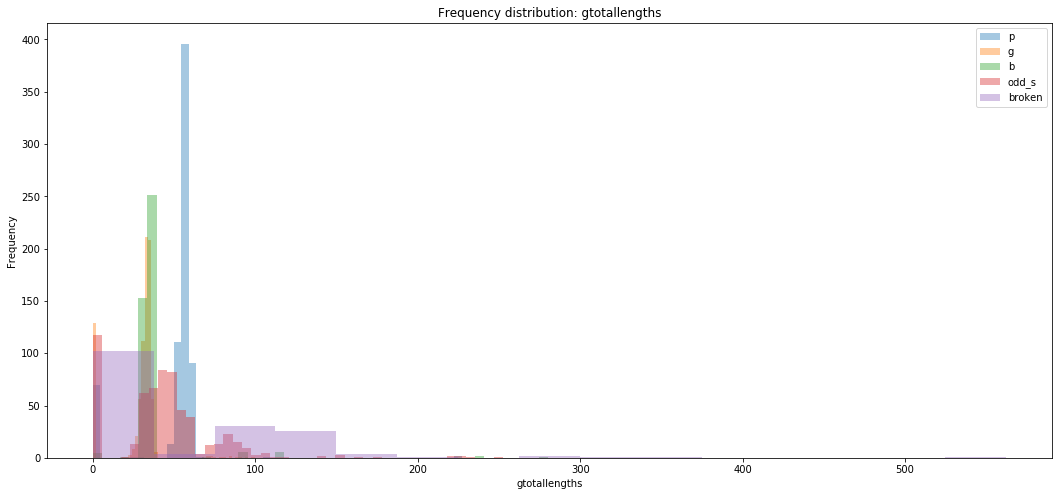

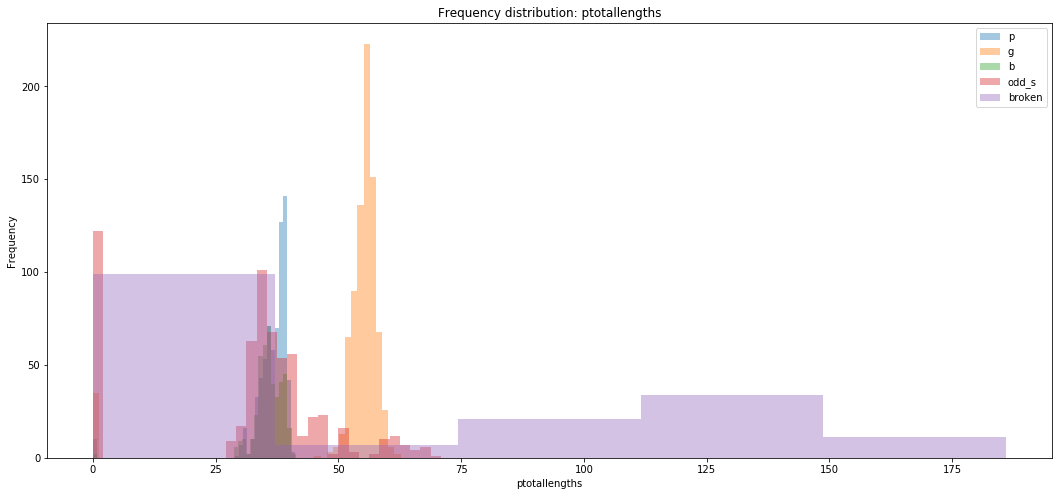

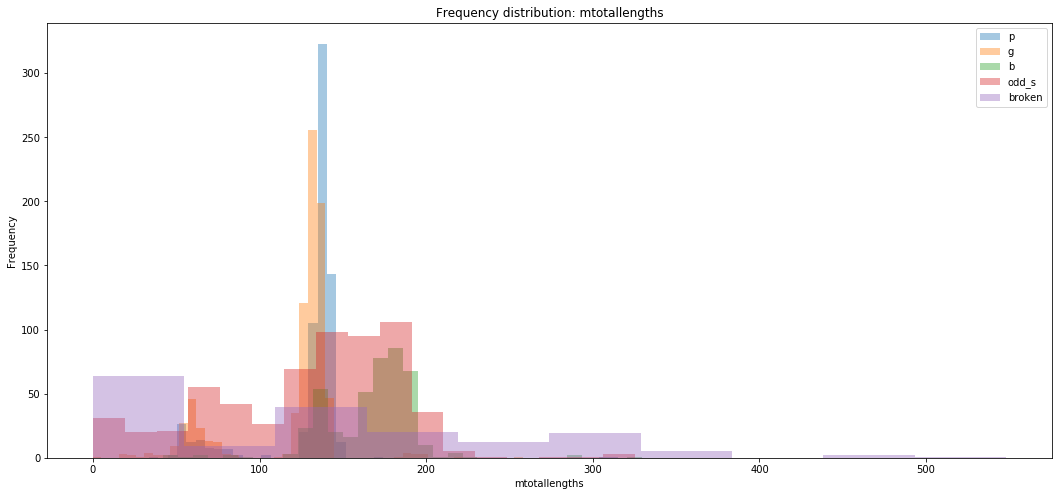

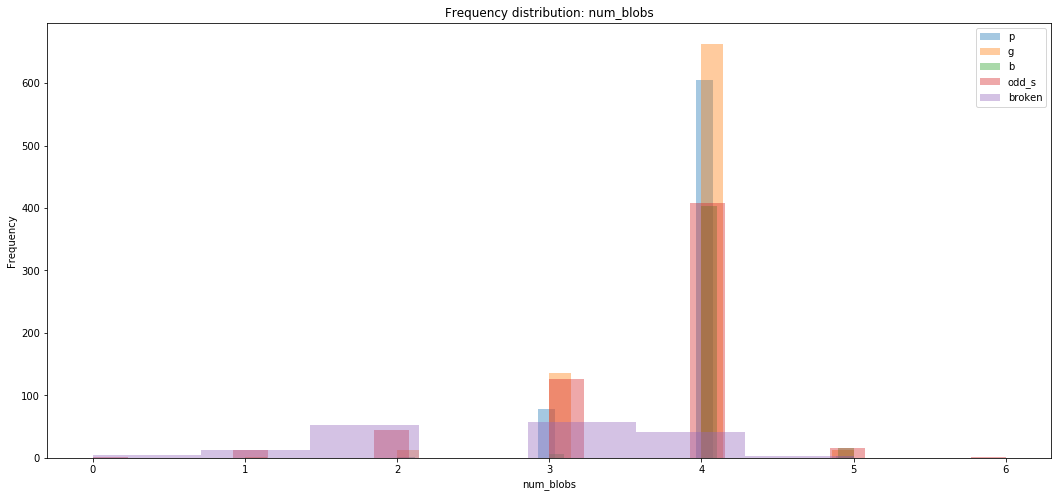

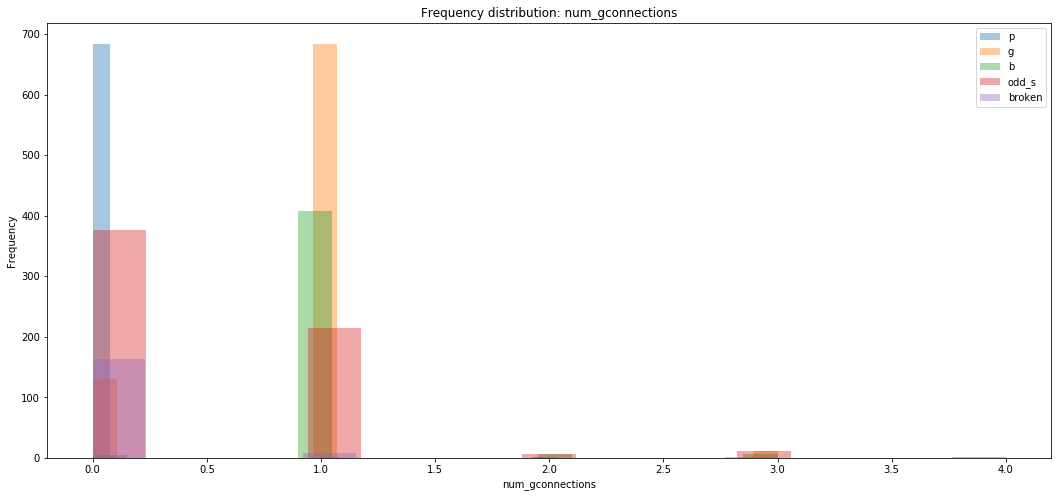

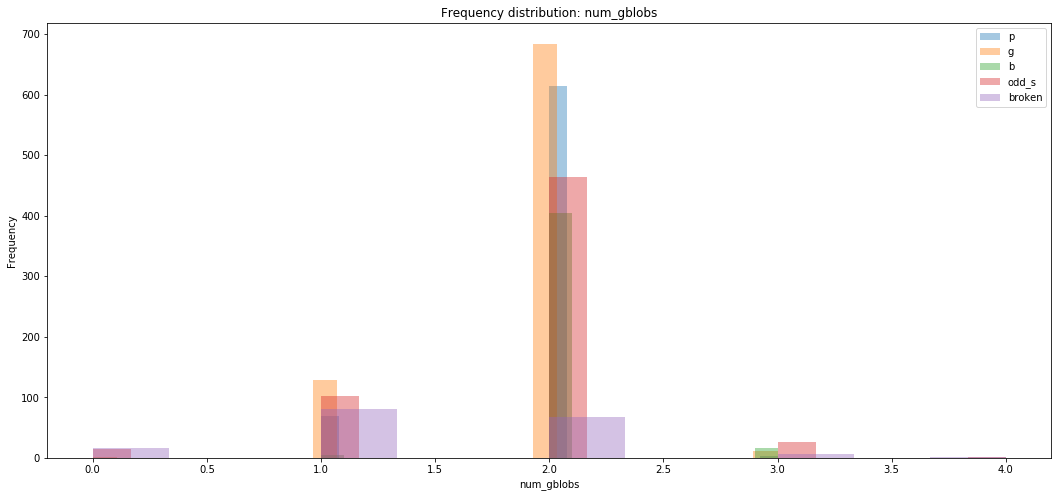

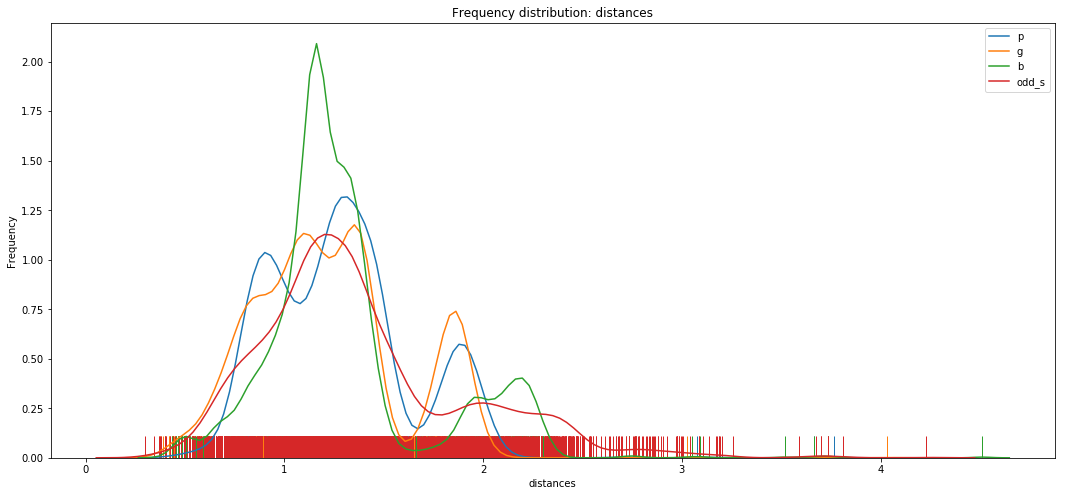

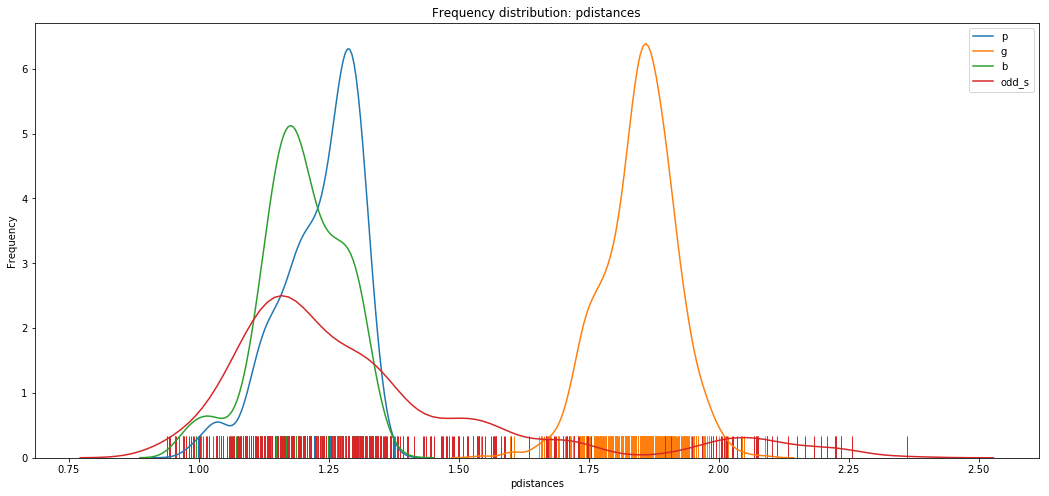

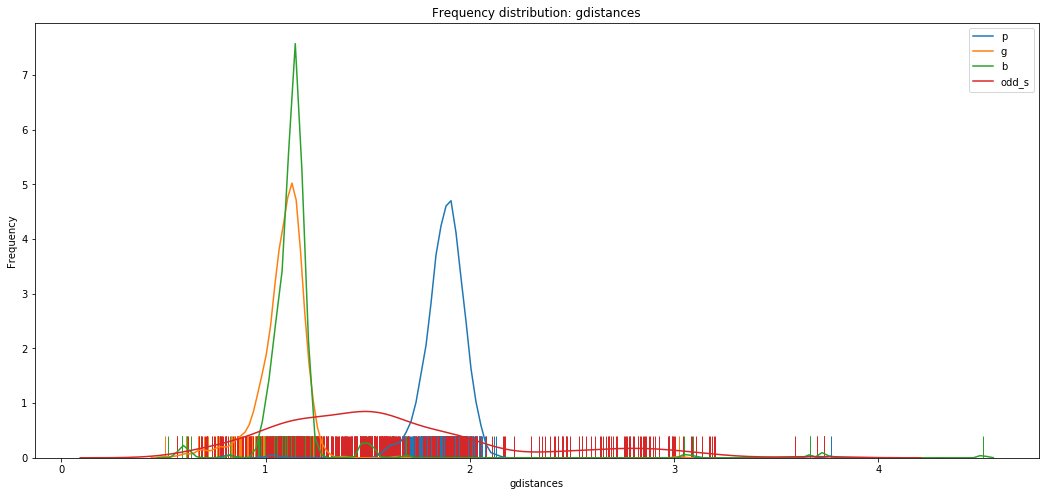

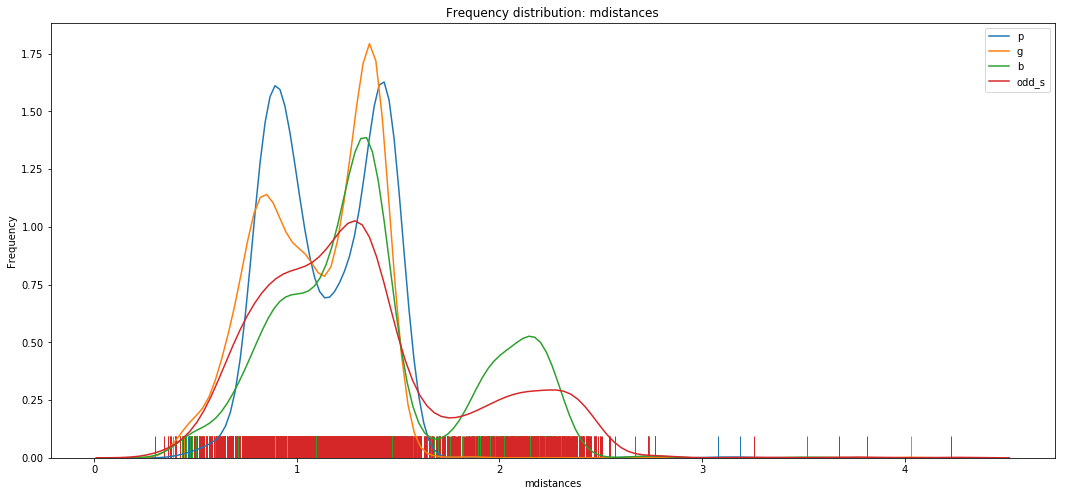

In [11]:
"""After first tests"""
# use area information from properties


for name in simplenames:
    klist = []
    for i in range(num_shape_cats):
        x = [h[name] for h in filtrates_props[i]]
        klist.append(x) #list of areas for every category
    print("%s averages: " %name)
    [print("%s : %.f " %(framesetnames[i], np.average(klist[i]))) for i in range(num_shape_cats)]
    print("%s variances: " %name)
    [print("%s : %.f " %(framesetnames[i], np.var(klist[i]))) for i in range(num_shape_cats)]    
    fig, ax = plt.subplots(figsize=(18,8))
    #plt.xticks(np.arange(0, 2501, 75))
    plt.title("Frequency distribution: " + name)
    plt.xlabel(name)
    plt.ylabel("Frequency")
    for j in range(0, num_shape_cats):
        x = klist[j]
        sns.distplot(x, hist = True, kde=False,rug=False, label = framesetnames[j])
    plt.legend() 
    
    

    
    
print(len(klist[0]))
for name in distances:
    klist = []
    for i in range(num_shape_cats):
        x = [d for lis in [h[name] for h in filtrates_props[i]] for d in lis]
        klist.append(x) #list of areas for every category
    print(len(klist[0]))
    print("%s averages: " %name)
    [print("%s : %.f " %(framesetnames[i], np.average(klist[i]))) for i in range(num_shape_cats)]
    print("%s variances: "  %name)
    [print("%s : %.f " %(framesetnames[i], np.var(klist[i]))) for i in range(num_shape_cats)]    
    fig, ax = plt.subplots(figsize=(18,8))
    #plt.xticks(np.arange(0, 2501, 75))
    plt.title("Frequency distribution: " +  name)
    plt.xlabel( name)
    plt.ylabel("Frequency")
    for j in range(0, num_shape_cats-1):
        x = klist[j]
        sns.distplot(x, hist = False, rug=True, label = framesetnames[j])



"""Broken objects are filtered out by their area and we then move on to identifying odd shaped objects 
    from the remaining frames"""
framesets.remove(broken_frames)
framesetnames.remove("broken")

num_mconnections averages: 
p : 4 
g : 4 
b : 3 
odd_s : 2 
broken : 1 
num_mconnections variances: 
p : 0 
g : 0 
b : 0 
odd_s : 1 
broken : 1 
totallengths averages: 
p : 233 
g : 221 
b : 241 
odd_s : 193 
broken : 237 
totallengths variances: 
p : 426 
g : 67 
b : 1417 
odd_s : 9257 
broken : 46107 
num_pconnections averages: 
p : 1 
g : 0 
b : 1 
odd_s : 1 
broken : 0 
num_pconnections variances: 
p : 0 
g : 0 
b : 0 
odd_s : 0 
broken : 0 
num_pblobs averages: 
p : 2 
g : 2 
b : 2 
odd_s : 2 
broken : 1 
num_pblobs variances: 
p : 0 
g : 0 
b : 0 
odd_s : 0 
broken : 0 
num_connections averages: 
p : 5 
g : 5 
b : 5 
odd_s : 3 
broken : 1 
num_connections variances: 
p : 0 
g : 0 
b : 0 
odd_s : 3 
broken : 1 
gtotallengths averages: 
p : 57 
g : 33 
b : 36 
odd_s : 44 
broken : 53 
gtotallengths variances: 
p : 100 
g : 7 
b : 375 
odd_s : 1248 
broken : 6298 
ptotallengths averages: 
p : 37 
g : 55 
b : 36 
odd_s : 28 
broken : 51 
ptotallengths variances: 
p : 5 
g : 5 
b : 6 

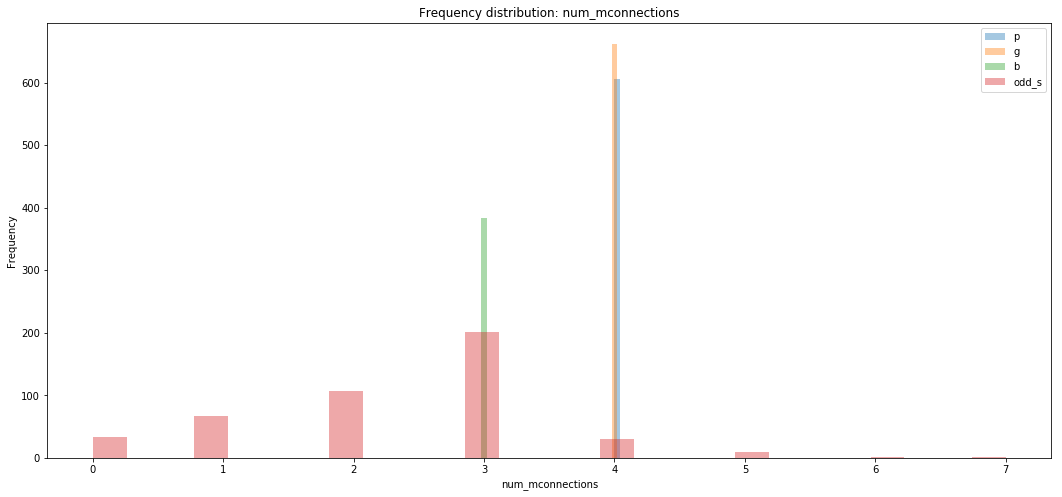

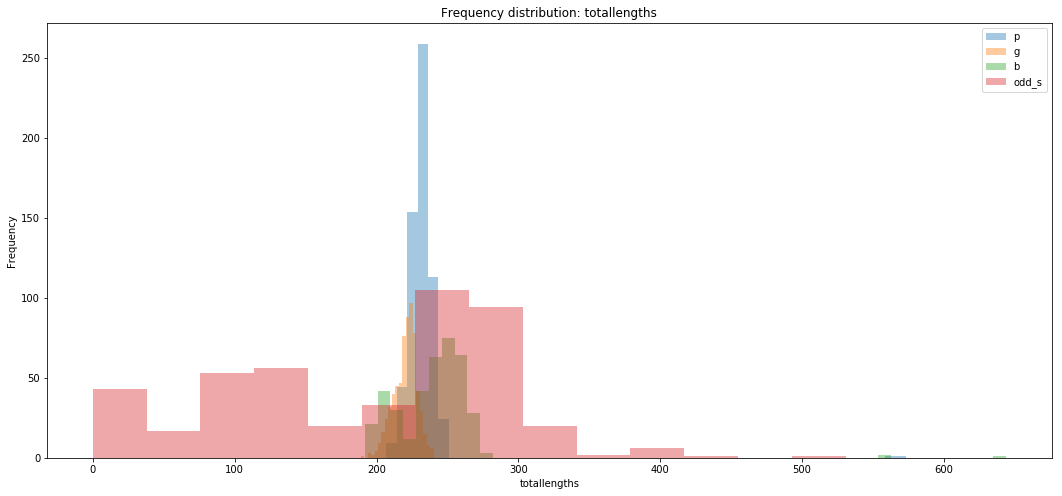

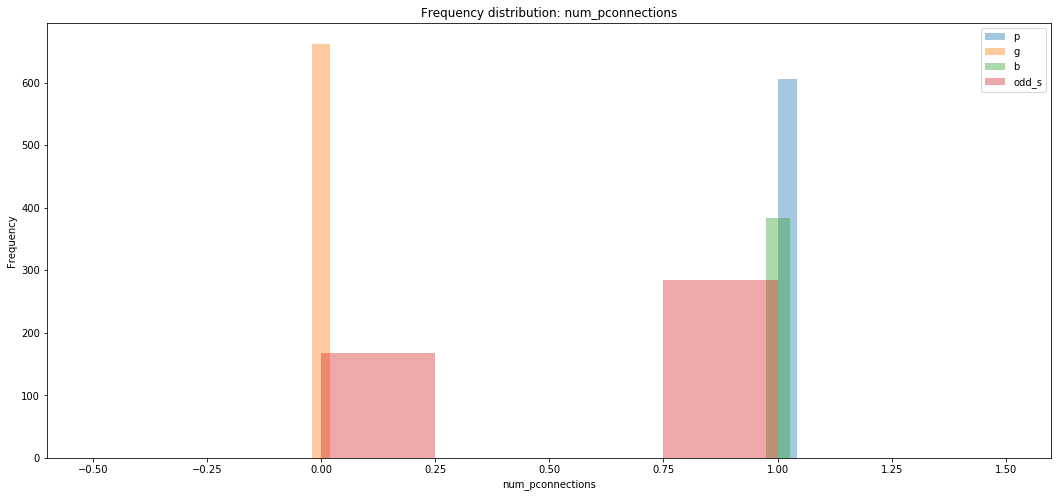

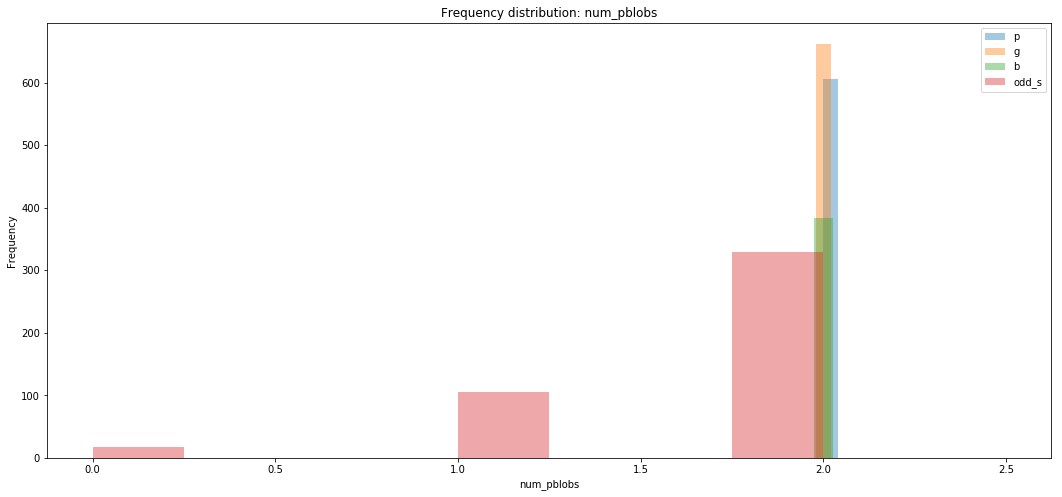

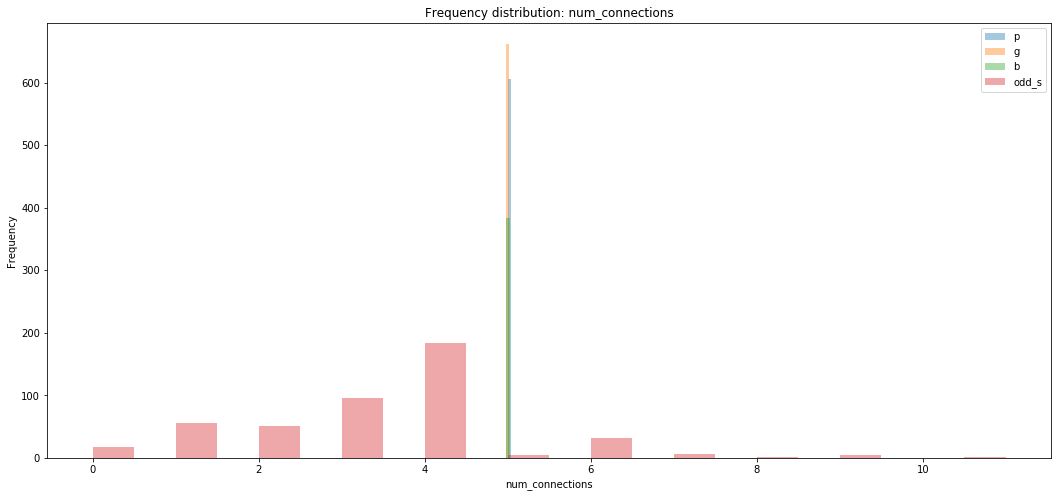

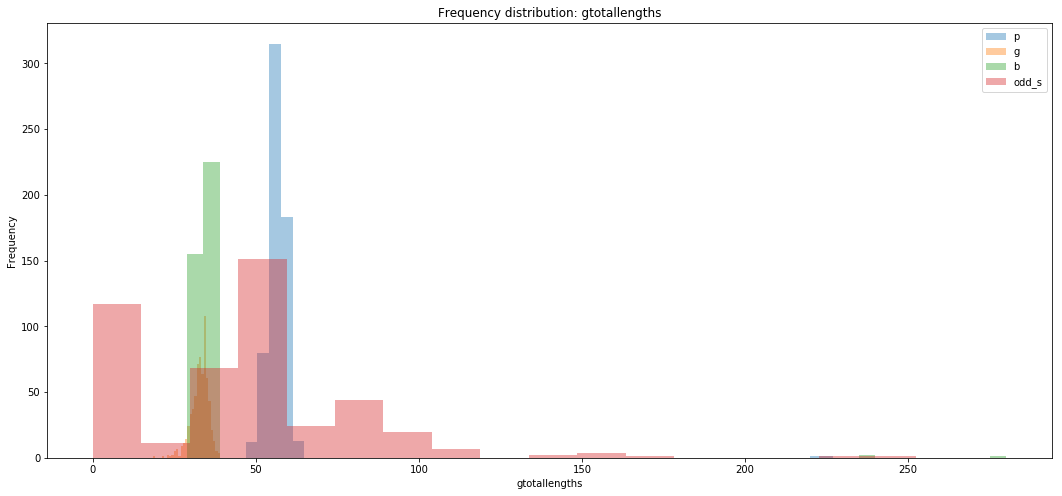

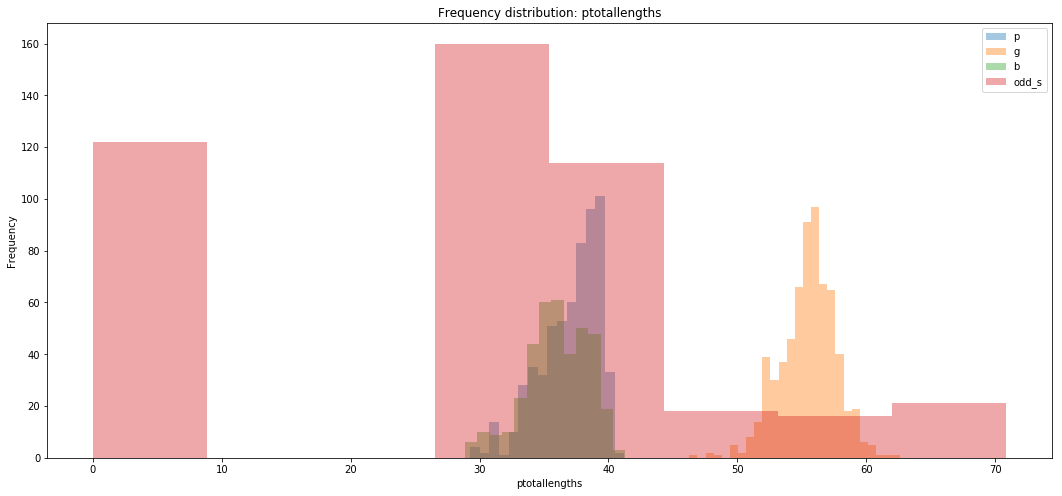

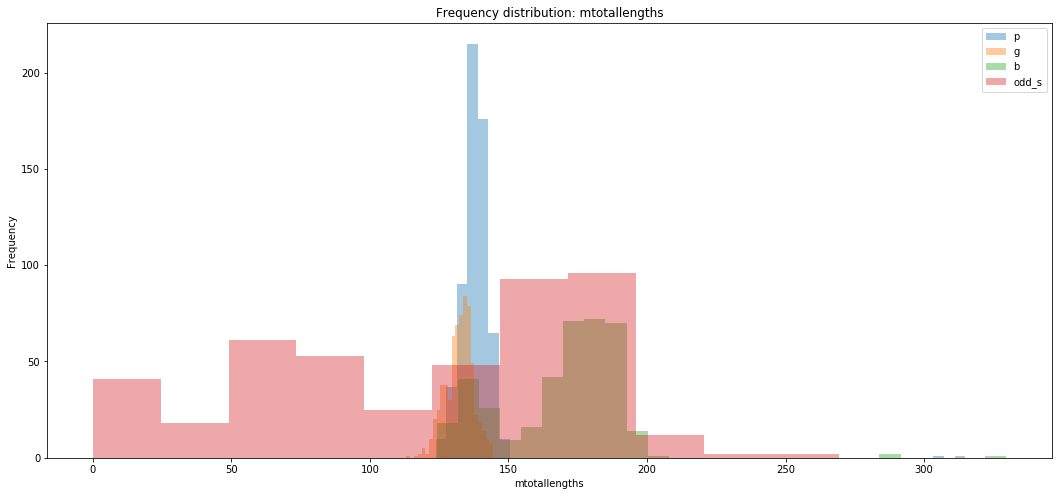

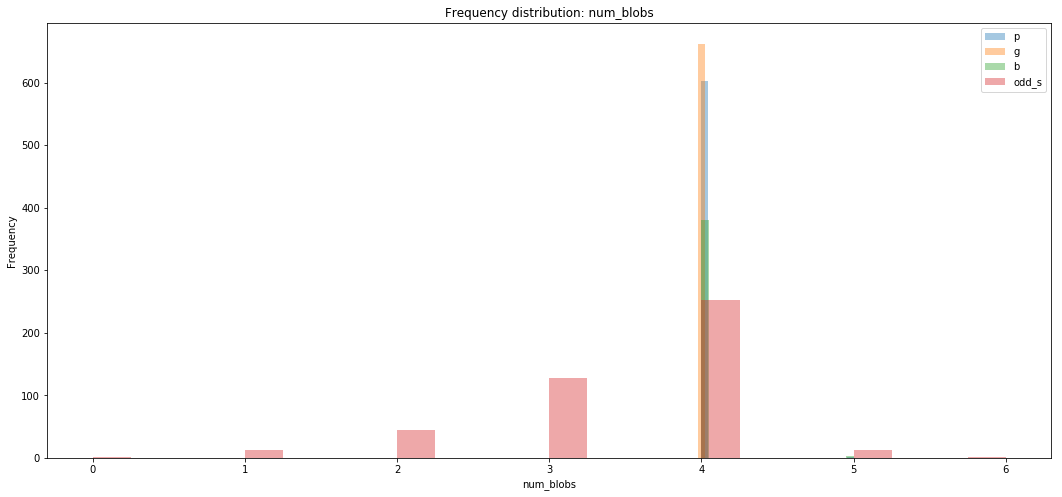

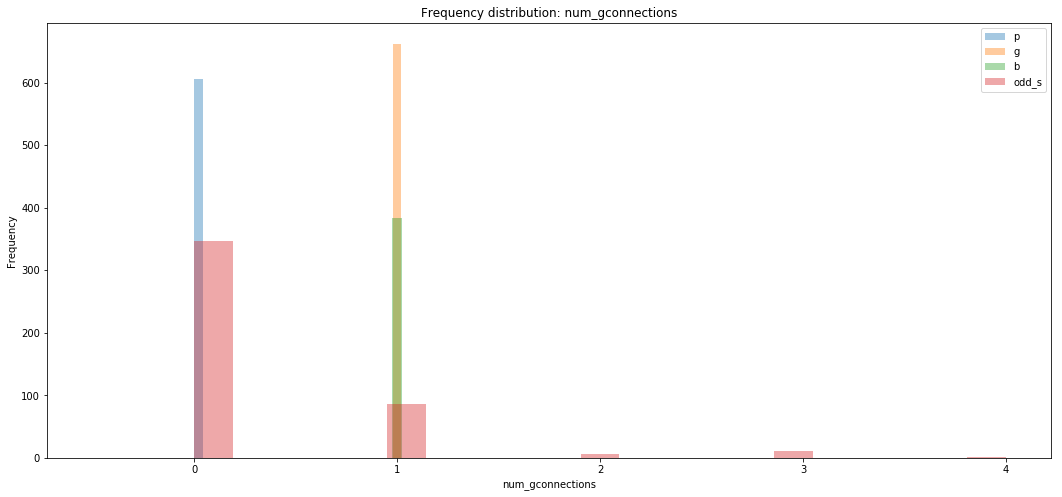

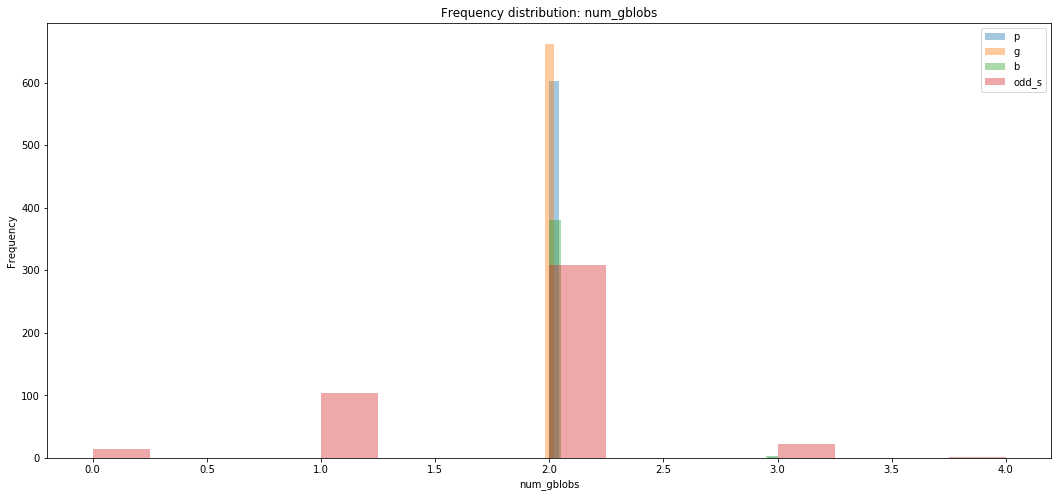

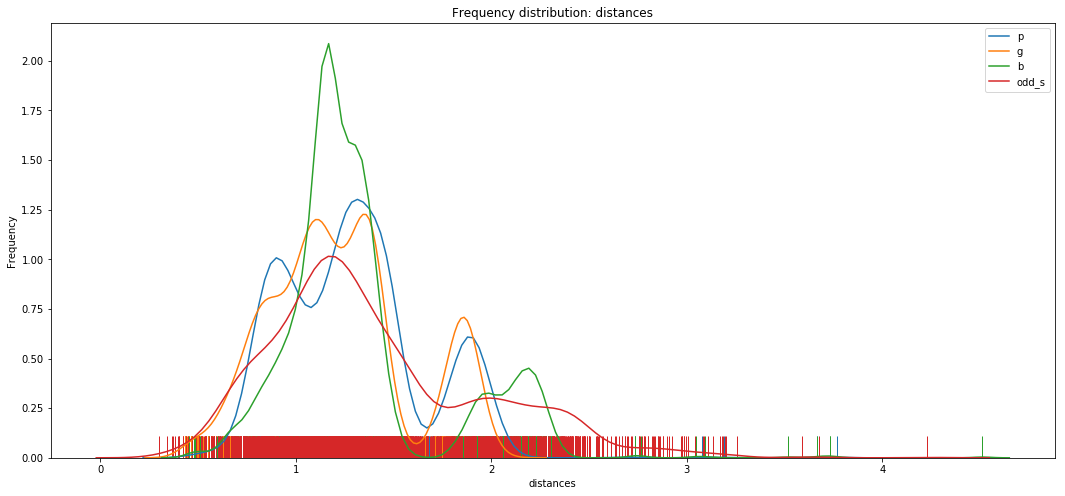

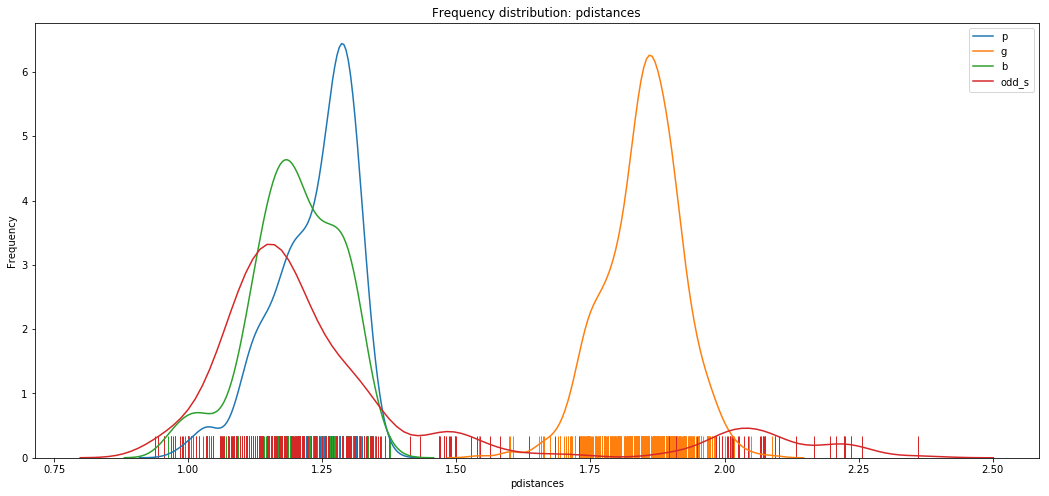

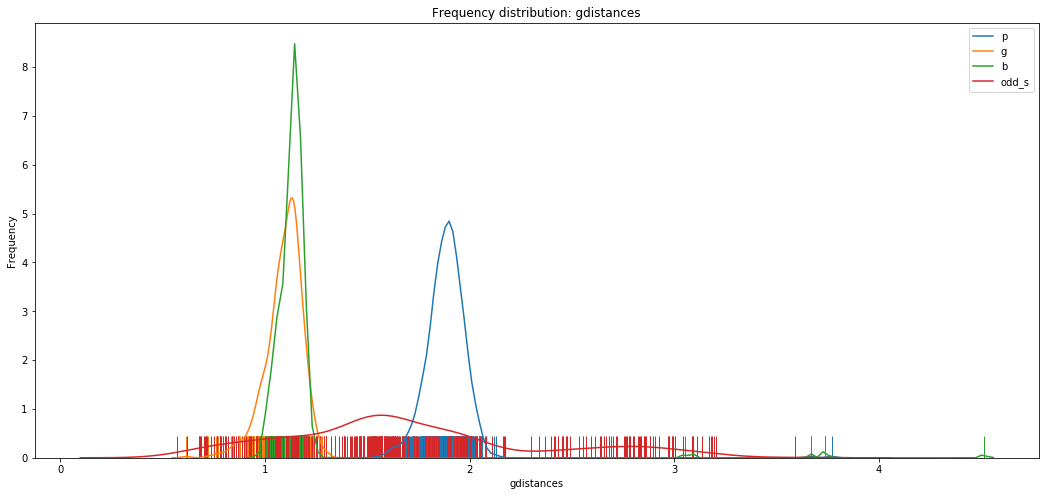

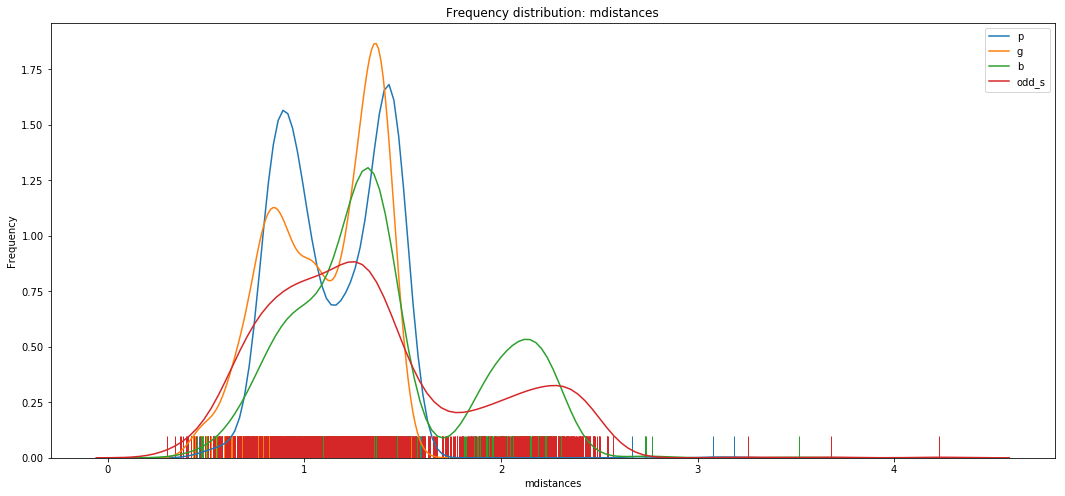

In [12]:

"""Correctly classified"""
# use area information from properties


for name in simplenames:
    klist = []
    for i in range(num_shape_cats):
        x = [h[name] for h in passes[i]]
        klist.append(x) #list of areas for every category
    print("%s averages: " %name)
    [print("%s : %.f " %(framesetnames[i], np.average(klist[i]))) for i in range(num_shape_cats)]
    print("%s variances: " %name)
    [print("%s : %.f " %(framesetnames[i], np.var(klist[i]))) for i in range(num_shape_cats)]    
    fig, ax = plt.subplots(figsize=(18,8))
    #plt.xticks(np.arange(0, 2501, 75))
    plt.title("Frequency distribution: " + name)
    plt.xlabel(name)
    plt.ylabel("Frequency")
    for j in range(0, num_shape_cats-1):
        x = klist[j]
        sns.distplot(x, hist = True, kde=False,rug=False, label = framesetnames[j])
    plt.legend() 
    
    

    
    
print(len(klist[0]))
for name in distances:
    klist = []
    for i in range(num_shape_cats):
        x = [d for lis in [h[name] for h in passes[i]] for d in lis]
        klist.append(x) #list of areas for every category
    print(len(klist[0]))
    print("%s averages: " %name)
    [print("%s : %.f " %(framesetnames[i], np.average(klist[i]))) for i in range(num_shape_cats)]
    print("%s variances: "  %name)
    [print("%s : %.f " %(framesetnames[i], np.var(klist[i]))) for i in range(num_shape_cats)]    
    fig, ax = plt.subplots(figsize=(18,8))
    #plt.xticks(np.arange(0, 2501, 75))
    plt.title("Frequency distribution: " +  name)
    plt.xlabel( name)
    plt.ylabel("Frequency")
    for j in range(0, num_shape_cats-1):
        x = klist[j]
        sns.distplot(x, hist = False, rug=True, label = framesetnames[j])
